# Количественный контент-анализ 

In [ ]:
!pip install pymorphy2 # pymorphy3
!pip install wordcloud

# !pip install Pillow==9.5.0

In [20]:
import pymorphy2
import pandas as pd
from string import punctuation, digits

In [62]:
positive_str = """
“Победа”, “успех”, “прекращение огня”, “предотвратила”, “президент”, “глава”, 
“государство”, “гуманитарный”, “помощь”, “союзник”, “безопасность”, “российские военные”
"""

neut_str = """
“договор”, “исключила”, “сила”, “армия”, “поддержка”, “гражданский”, 
“курд”, “курдский”, “переговоры”, “вмешательство”, “ситуация”, “солдат”, “самолет”, 
“авиация”, “население”, “эвакуация”, “правительство”, “бомбардировка”
"""

neg_str = """
“смерть”, “убийство”, “убито”, “пострадали”, “удар”, “повстанец”, “война”, “восстание”, 
“погибнуть”, “битва”, “джихадистов”, “захватить”, “нападение”, “конфликт”, 
“интервенция”, “ИГ”, “ИГИЛ”, “режим“
"""

In [64]:
pos_words = positive_str.strip().lower().replace('“', '').replace('”', '').replace("\n", ' ').split(",")
pos_words = [normalize(w.strip()) for w in pos_words]

neut_words = neut_str.strip().lower().replace('“', '').replace('”', '').replace("\n", ' ').split(",")
neut_words = [normalize(w.strip()) for w in neut_words]

neg_words = neg_str.strip().lower().replace('“', '').replace('”', '').replace("\n", ' ').split(",")
neg_words = [normalize(w.strip()) for w in neg_words] + ["иг"]

print(pos_words, neut_words, neg_words)

['победа', 'успех', 'прекращение огонь', 'предотвратить', 'президент', 'глава', 'государство', 'гуманитарный', 'помощь', 'союзник', 'безопасность', 'российский военный'] ['договор', 'исключить', 'сила', 'армия', 'поддержка', 'гражданский', 'курд', 'курдский', 'переговоры', 'вмешательство', 'ситуация', 'солдат', 'самолёт', 'авиация', 'население', 'эвакуация', 'правительство', 'бомбардировка'] ['смерть', 'убийство', 'убито', 'пострадать', 'удар', 'повстанец', 'война', 'восстание', 'погибнуть', 'битва', 'джихадист', 'захватить', 'нападение', 'конфликт', 'интервенция', 'иго', 'игил', 'режим', 'иг']


In [68]:
df = pd.read_excel("источники курсовая .xlsx", header = 1)
df = df.dropna()
df["Статья полная"] = df["Заголовок "] + " " + df["Статья .1"]

In [110]:
def normalize(text):
    to_exclude = punctuation + digits + "–«»—"
    text = text.lower()

    # clean text
    for char in to_exclude:
        text = text.replace(char, " ")

    # list of words    
    words = text.split()

    # to infinitive
    morph = pymorphy2.MorphAnalyzer()
    words_norm = [morph.parse(word)[0].normal_form for word in words]
    text_norm = " ".join(words_norm)
    return text_norm

In [111]:
df["Статья норм"] = df["Статья полная"].apply(normalize)

In [112]:
def count_positive(text):
    count = 0
    n = len(text.split())
    for pw in pos_words:
        count += text.count(pw)
    return count / n * 100

def count_negative(text):
    count = 0
    n = len(text.split())
    for pw in neg_words:
        count += text.count(pw)
    return count / n * 100

def count_neutral(text):
    count = 0
    n = len(text.split())
    for pw in neut_words:
        count += text.count(pw)
    return count / n * 100

In [113]:
df["positive"] = df["Статья норм"].apply(count_positive)
df["negative"] = df["Статья норм"].apply(count_negative)
df["neutral"] = df["Статья норм"].apply(count_neutral)

In [114]:
df["class"] = df.loc[:, "positive" : "neutral"].idxmax(axis = 1)

In [135]:
df.to_excel("массив_1_1.xlsx")

In [115]:
df["class"].value_counts()

negative    61
neutral     34
positive    16
Name: class, dtype: int64

In [116]:
df.groupby(["Издательство ", "class"])["class"].count() / df.groupby(["Издательство "])["class"].count() * 100

Издательство   class   
Le Figaro      negative    45.312500
               neutral     39.062500
               positive    15.625000
Le Monde       negative    68.085106
               neutral     19.148936
               positive    12.765957
Name: class, dtype: float64

In [117]:
df.groupby(["Издательство "])["positive", "negative", "neutral"].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,positive,negative,neutral
Издательство,,,
Le Figaro,1.451212,3.013815,2.553589
Le Monde,1.449073,3.318663,2.301872


In [118]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [119]:
full = " ".join(df["Статья норм"].to_list())

In [120]:
file = open("stopwords-ru.txt", encoding = "UTF-8")
lines = file.readlines()
stop_ru = [line.strip() for line in lines]

In [130]:
stop_ru2 = stop_ru + ['российский', 
                      'сирийский', 
                      'россия', 'сирия', 'иго']

In [131]:
wcloud = WordCloud(stopwords = stop_ru2,
                  width = 1600,
                  height = 900).generate(full)

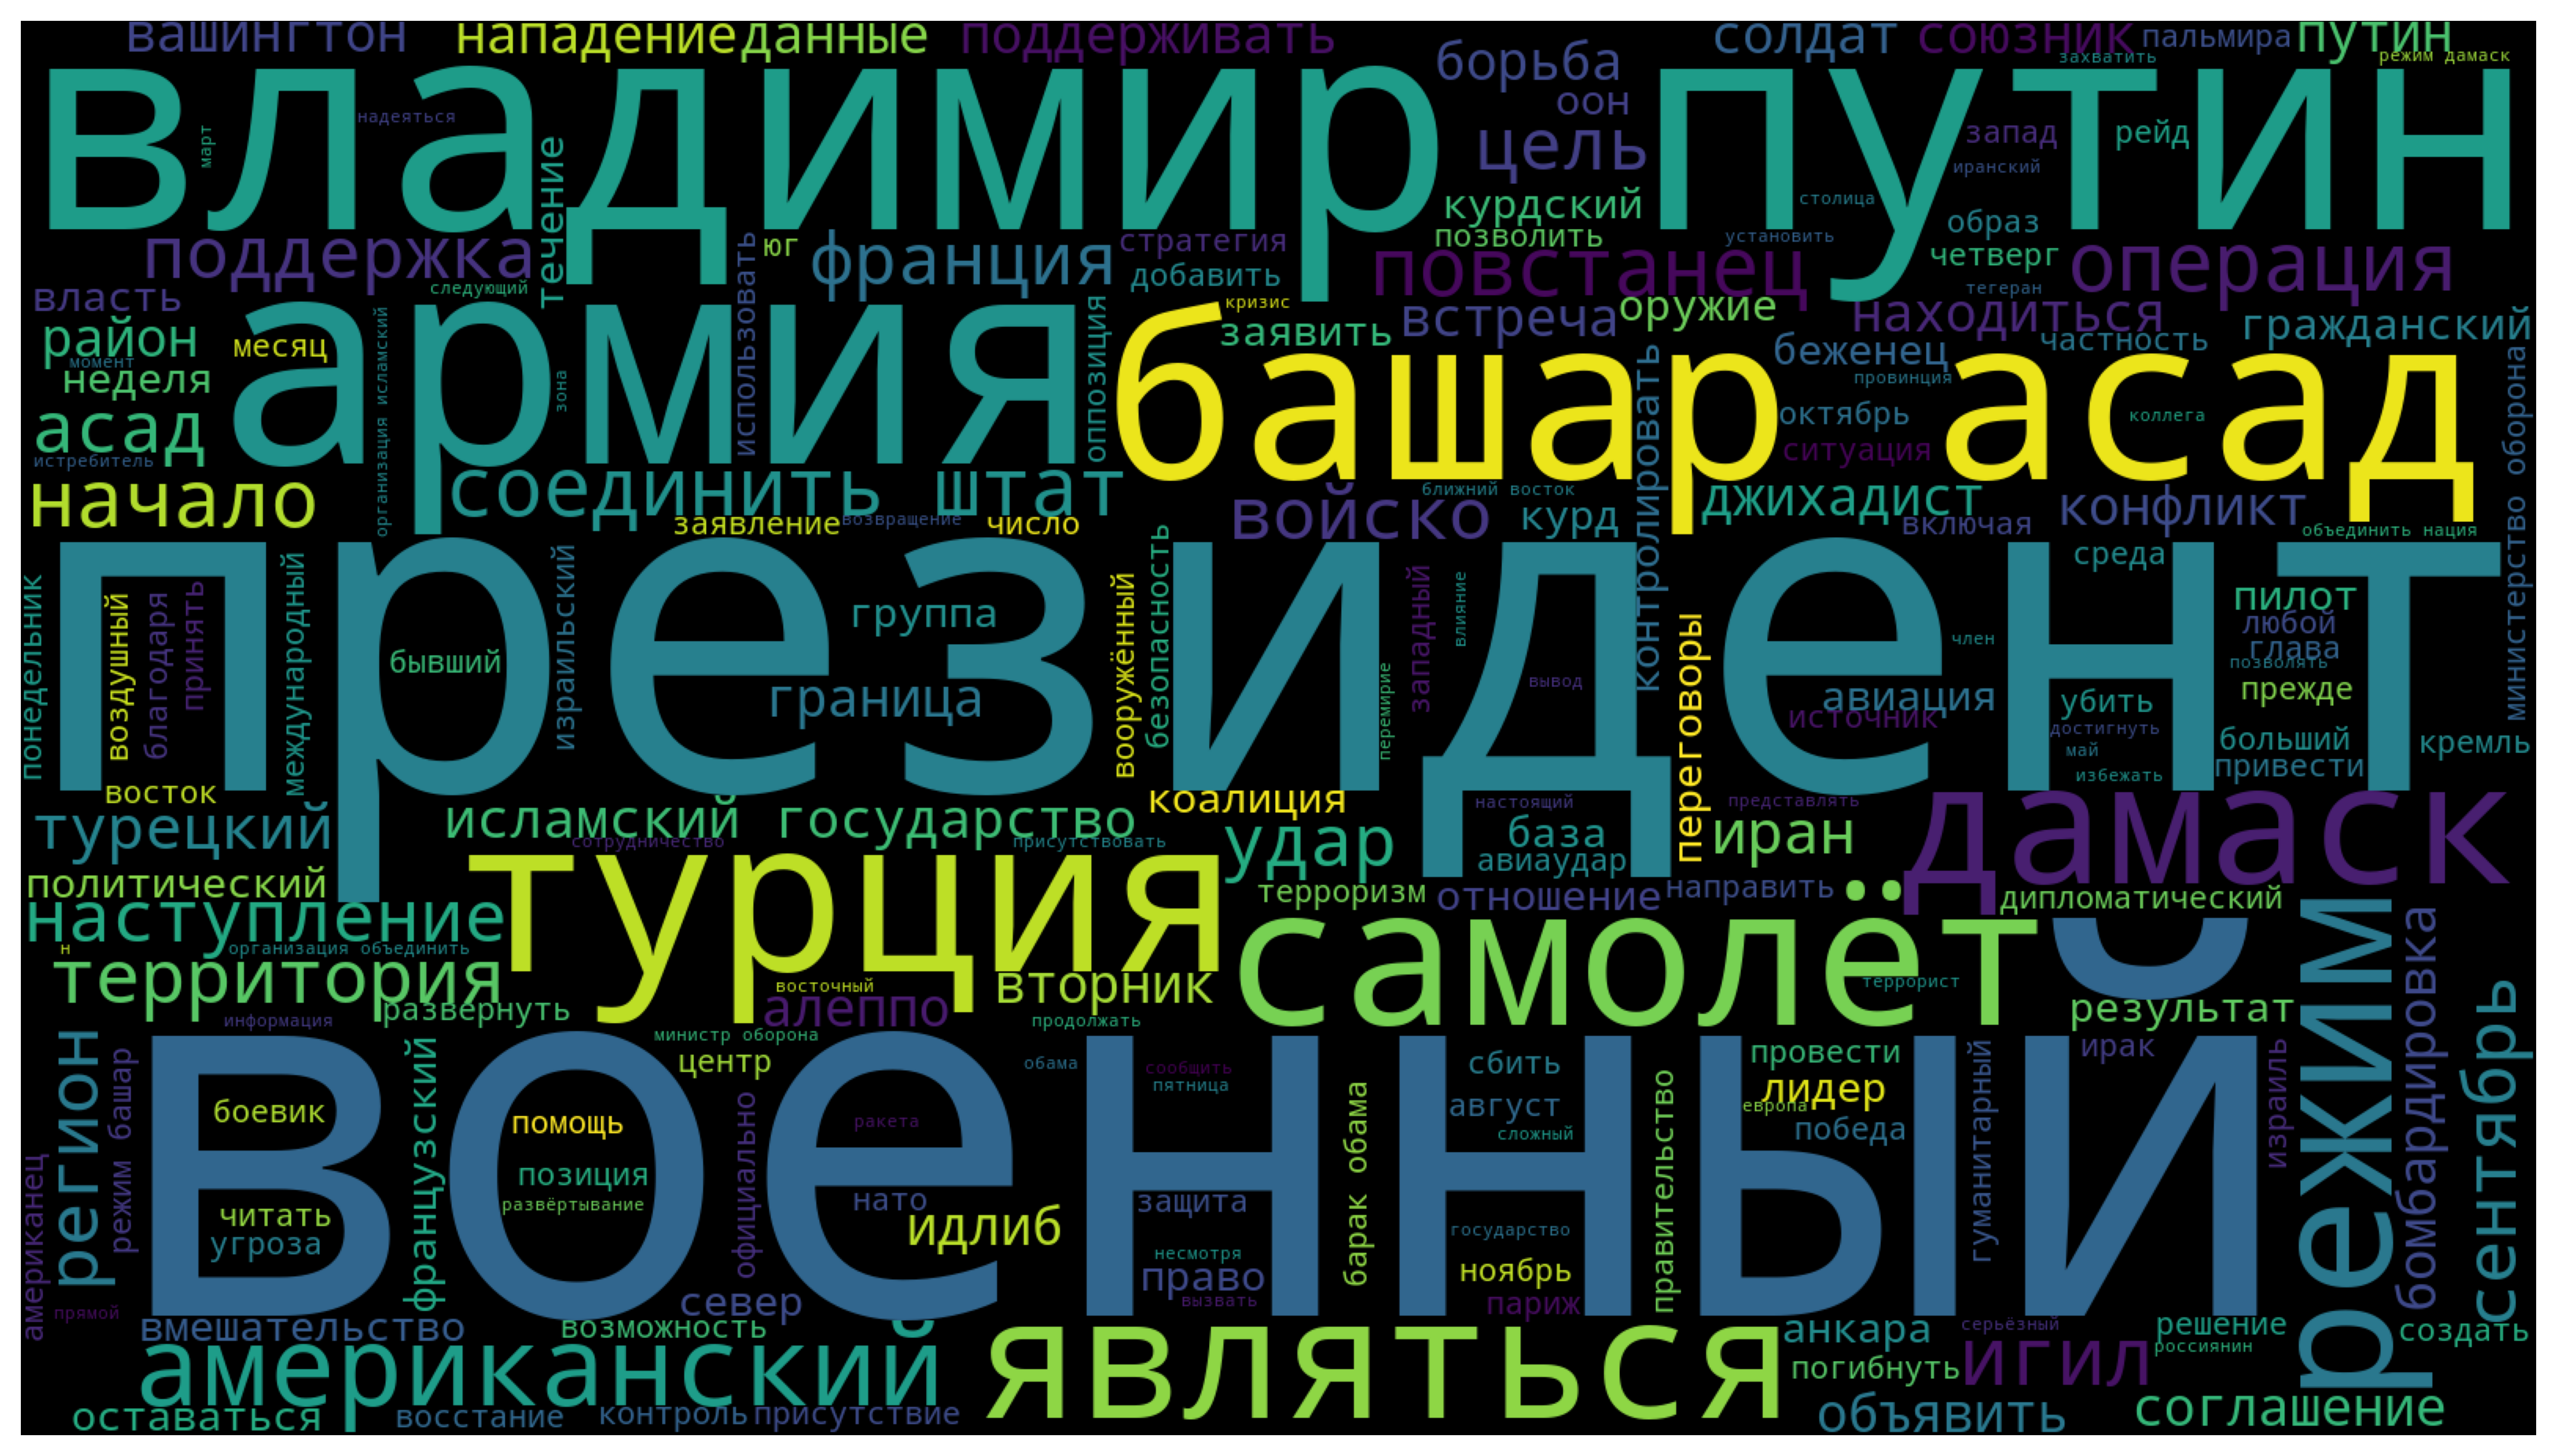

In [134]:
fig, ax = plt.subplots(figsize = (16, 9), 
                       dpi = 300);
ax.imshow(wcloud)
ax.axis("off")

fig.savefig("cloud.png")